<a href="https://colab.research.google.com/github/veyselalevcan/Time_Series/blob/main/tsa_store_item_demand_forecasting_wtih_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lightgbm

In [ ]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', 500)

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/demand_forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/demand_forecasting/test.csv', parse_dates=['date'])
sample_sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/demand_forecasting/sample_submission.csv')

In [ ]:
df = pd.concat([train, test], sort= False)
df

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


#####################################################
# EDA
#####################################################

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

In [ ]:
df['date'].min(), df['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [ ]:
df[['store']].nunique(), df[['item']].nunique()

(store    10
 dtype: int64,
 item    50
 dtype: int64)

In [ ]:
df.groupby(['store'])['item'].nunique()
# her magazada aynı 50 urun satılmıs mı?

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [ ]:
df.groupby(['store', 'item']).agg({'sales': ['sum', 'mean', 'median', 'std']})
# hangi magazada hangi urun ne kadar satıldı?

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

#####################################################
# FEATURE ENGINEERING
#####################################################

In [ ]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [ ]:
df = create_date_features(df)

In [ ]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]


########################
# Random Noise
########################

Yeni uretilecek degskenlerim bagımlı degısken uzerinden turetılecegı ıcın, asırı ogrenmenın onune gecmek amacıyla gurultu eklemek ıstıyorum. Dataframe boyutunda normal dagılımlı bu degerlerı olusturacagım Sales oriented degıskenıme ekleyecegım.

In [ ]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

########################
# Lag/Shifted Features
########################

Gecikme Feature. Gecmis donem satıs rakamları uzerinden feature turetmek ıstıyorum. Verinin magaza urun ve tarihe gore sıralı olması gerekıyor. Dogru sıralama yapabılmek ıcın.

In [ ]:
df.sort_values(by= ['store', 'item', 'date'], axis=0, inplace=True)

In [ ]:
# Satısların gercek degerleri uzerinden gecikmeyi hesaplayalım. Ilk 10 satıs uzerinden gorellim:
# shift() fn ile bu gecikmeyi hesaplarım. Adım sayısı verilerek.
# Gecikme bir onceki degerdir. yt bugun ki deger yt-1 bir onceki
pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

,sales,lag1,lag2,lag3,lag4
0,13.0,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN
4,10.0,13.0,14.0,11.0,13.0
5,12.0,10.0,13.0,14.0,11.0
6,10.0,12.0,10.0,13.0,14.0
7,9.0,10.0,12.0,10.0,13.0
8,12.0,9.0,10.0,12.0,10.0
9,9.0,12.0,9.0,10.0,12.0


Satıs rakamlarında bugun satılan 13 u en cok etkıleyen kendisinden bır oncekı degerdır. Ben de bu degerleri yeni feature urettım.

Sales bugun= yt

Lag1= yt-1

Lag2= yt-2

Lagn= yt-n

In [ ]:
df.groupby(["store", "item"])['sales'].head()

0         13.0
1         11.0
2         14.0
3         13.0
4         10.0
          ... 
911174    33.0
911175    37.0
911176    46.0
911177    51.0
911178    41.0
Name: sales, Length: 2500, dtype: float64

In [ ]:
df.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1))

0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64

In [ ]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe


In [ ]:
# 3 aylık tahmin yapacagım ıcın 3 ay oncekı degerlerı dıkkate aldım
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,...,39.409520,53.905369,69.576669,69.021746,64.925286,80.090185,79.405031,58.420014,99.143448,73.251624
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,...,60.689640,47.737218,64.721190,59.836128,77.532409,79.693166,78.267748,71.168447,79.367344,65.470043
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,...,57.951488,64.659095,74.023472,65.061974,71.889834,87.677765,82.217640,68.182594,98.840148,74.909922
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,...,73.459500,77.314818,70.569086,70.890534,65.788676,79.525597,89.316981,68.533868,77.592185,84.206425


In [ ]:
check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int64
is_month_end               int64
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

########################
# Rolling Mean Features
########################

In [ ]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,12.0,NaN,NaN
2,14.0,12.5,12.666667,NaN
3,13.0,13.5,12.666667,NaN
4,10.0,11.5,12.333333,12.2
5,12.0,11.0,11.666667,12.0
6,10.0,11.0,10.666667,11.8
7,9.0,9.5,10.333333,10.8
8,12.0,10.5,10.333333,10.6
9,9.0,10.5,10.000000,10.4


In [ ]:
# rolling yaparken adım sayısı kendisi dahil geriye dogru toplam alır. Yarını tahmin etmek istiyorsam bir adım geriden baslamalıyım.
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN
3,13.0,12.5,12.666667,NaN
4,10.0,13.5,12.666667,NaN
5,12.0,11.5,12.333333,12.2
6,10.0,11.0,11.666667,12.0
7,9.0,11.0,10.666667,11.8
8,12.0,9.5,10.333333,10.8
9,9.0,10.5,10.333333,10.6


In [ ]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [ ]:
df = roll_mean_features(df, [365, 546])
df # 1 ve 1,5 yıl oncesi veriye odaklanıyorum. 3 ve 6 ay denendı ama anlamlı sonuc vermedi.

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,...,69.576669,69.021746,64.925286,80.090185,79.405031,58.420014,99.143448,73.251624,87.435899,86.389961
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,...,64.721190,59.836128,77.532409,79.693166,78.267748,71.168447,79.367344,65.470043,90.115907,84.128475
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,...,74.023472,65.061974,71.889834,87.677765,82.217640,68.182594,98.840148,74.909922,88.492327,82.710974
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,...,70.569086,70.890534,65.788676,79.525597,89.316981,68.533868,77.592185,84.206425,89.609327,84.771185


########################
# Exponentially Weighted Mean Features
########################

In [ ]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

,sales,roll2,ewm099,ewm095,ewm07,ewm02
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.947368
3,13.0,12.5,13.970201,13.855107,13.287770,12.704797
4,10.0,13.5,13.009702,13.042750,13.084686,12.790637
5,12.0,11.5,10.030097,10.152137,10.920146,12.109179
6,10.0,11.0,11.980301,11.907607,11.676595,12.085878
7,9.0,11.0,10.019803,10.095380,10.502722,11.686057
8,12.0,9.5,9.010198,9.054769,9.450748,11.214433
9,9.0,10.5,11.970102,11.852738,11.235259,11.342672


In [ ]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


In [ ]:
# alpha en yakın degere verılecek katsayı. lags gecikme degerleri 3 aylık tahmıne gore yazdım.
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
check_df(df)

##################### Shape #####################
(958000, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  \
0 2013-01-01      1     1   13.0 NaN      1             1            1   
1 2013-01-02      1     1   11.0 NaN      1             2            2   
2 2013-01-03      1     1   14.0 NaN      1             3            3   
3 2013-01-04      1  

########################
# One-Hot Encoding
########################

In [ ]:
# magazalar arasında buyukluk kucukluk yok rakamlar sadece temsil bunları duzenlemelıyız
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])


In [ ]:
check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
        date  sales  id  day_of_month  day_of_year  week_of_year  year  \
0 2013-01-01   13.0 NaN             1            1             1  2013   
1 2013-01-02   11.0 NaN             2            2             1  2013   
2 2013-01-03   14.0 NaN             3            3             1  2013   
3 2013-01-04   13.0 NaN             4            4             1  2013   
4 2013-01-05   10.0 NaN             5            5             1  2013   

   is_wknd  is_month_sta

########################
# Converting sales to log(1+sales)
########################

In [ ]:
# Agac yontemlerı ve sınıflandırma problemlerınde bu ıslemı yapmayabılırız. Bagımlı degıskenın logarıstması
# Iterasyon suresını kısaltmak ıcın, bagımlı degısken sayısal oldugundan standartlastırma yapıyoruz
df['sales'] = np.log1p(df["sales"].values)

check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
        date     sales  id  day_of_month  day_of_year  week_of_year  year  \
0 2013-01-01  2.639057 NaN             1            1             1  2013   
1 2013-01-02  2.484907 NaN             2            2             1  2013   
2 2013-01-03  2.708050 NaN             3            3             1  2013   
3 2013-01-04  2.639057 NaN             4            4             1  2013   
4 2013-01-05  2.397895 NaN             5            5             1  2013   

   is_

#####################################################
# Model
#####################################################

########################
## Custom Cost Function
########################

In [ ]:
# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
# Hatalarımızı SMAPE degerine gore ınceleyecegız:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [ ]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

########################
# Time-Based Validation Sets
########################

In [ ]:
# 2013'ten 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2017'nin ilk 3'ayı validasyon seti. Cunku 2018 ılk 3 ayını tahmın etmek ıstıyorum. En uygun senaryo ile validasyon yapıyoruz.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

# bagımsız degiskenleri seciyoruz:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

########################
# LightGBM ile Zaman Serisi Modeli
########################

In [ ]:
# LightGBM parameters, optimize edilmis sonuclar:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
# metric mae: l1, absolute loss, mean_absolute_error, regression_l1
# mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
# rmse, root square loss, root_mean_squared_error, l2_root
# mape, MAPE loss, mean_absolute_percentage_error

# num_leaves: bir ağaçtaki maksimum yaprak sayısı
# learning_rate: shrinkage_rate, eta
# feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
# max_depth: maksimum derinlik
# num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

# early_stopping_rounds: validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani
# hata düşmüyorsa modellemeyi durdur.
# hem train süresini kısaltır hem de overfit'e engel olur.
# nthread: num_thread, nthread, nthreads, n_jobs

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  feval=lgbm_smape)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.84905030838133

########################
# Değişken Önem Düzeyleri
########################

In [ ]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp



In [ ]:
plot_lgb_importances(model, num=200)

                        feature  split       gain
17          sales_roll_mean_546    941  54.271760
13                sales_lag_364   1249  13.432621
16          sales_roll_mean_365    612   9.799206
60   sales_ewm_alpha_05_lag_365    388   4.897299
18   sales_ewm_alpha_095_lag_91     90   2.364553
..                          ...    ...        ...
105                     item_33      0   0.000000
107                     item_35      0   0.000000
66                      store_4      0   0.000000
81                       item_9      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


,feature,split,gain
17,sales_roll_mean_546,941,54.271760
13,sales_lag_364,1249,13.432621
16,sales_roll_mean_365,612,9.799206
60,sales_ewm_alpha_05_lag_365,388,4.897299
18,sales_ewm_alpha_095_lag_91,90,2.364553
...,...,...,...
105,item_33,0,0.000000
107,item_35,0,0.000000
66,store_4,0,0.000000
81,item_9,0,0.000000


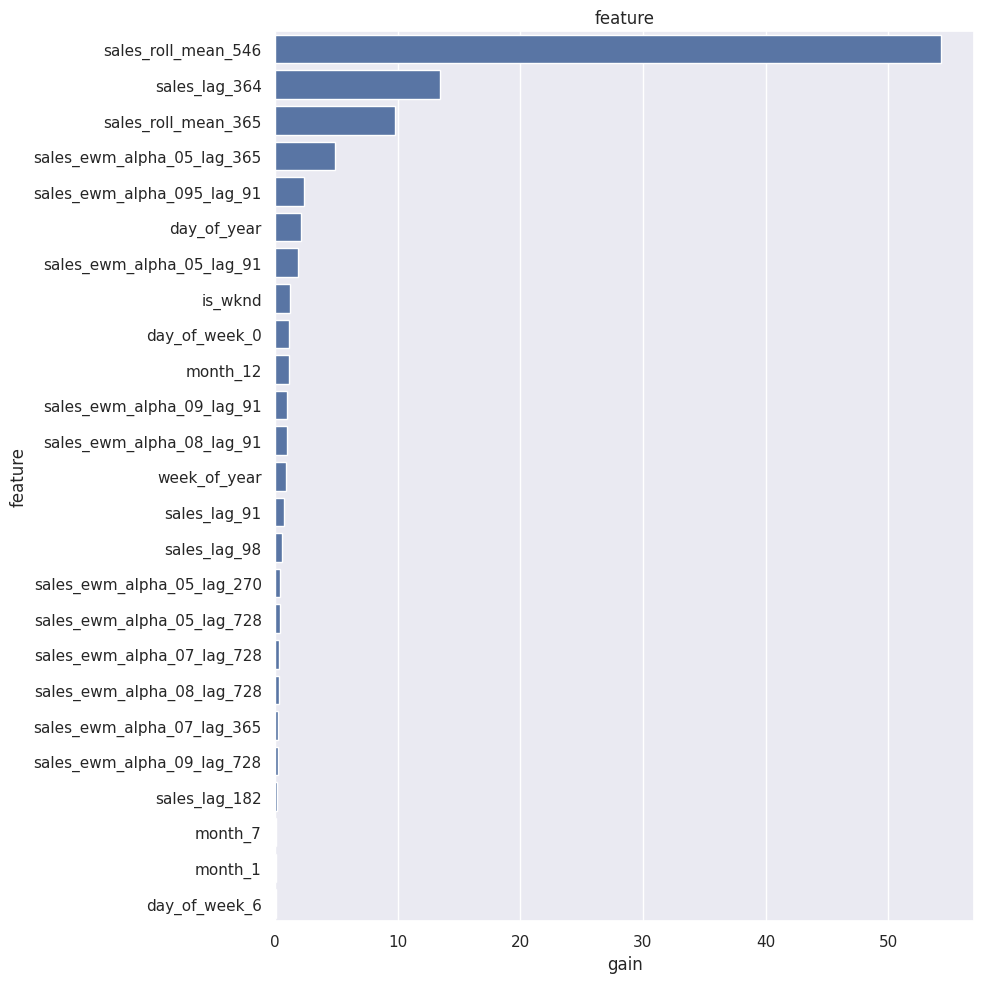

,feature,split,gain
17,sales_roll_mean_546,941,54.271760
13,sales_lag_364,1249,13.432621
16,sales_roll_mean_365,612,9.799206
60,sales_ewm_alpha_05_lag_365,388,4.897299
18,sales_ewm_alpha_095_lag_91,90,2.364553
...,...,...,...
105,item_33,0,0.000000
107,item_35,0,0.000000
66,store_4,0,0.000000
81,item_9,0,0.000000


In [ ]:
plot_lgb_importances(model, num=30, plot=True)

In [ ]:
# Feature Engineeringte uretttıgımız degıskenlerın katkısı 0 lanları cıkartabılırız. Iterasyonu hızlandırır.
feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

                        feature  split       gain
17          sales_roll_mean_546    941  54.271760
13                sales_lag_364   1249  13.432621
16          sales_roll_mean_365    612   9.799206
60   sales_ewm_alpha_05_lag_365    388   4.897299
18   sales_ewm_alpha_095_lag_91     90   2.364553
..                          ...    ...        ...
105                     item_33      0   0.000000
107                     item_35      0   0.000000
66                      store_4      0   0.000000
81                       item_9      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


111

########################
# Final Model
########################

In [ ]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)


In [ ]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)
test_preds # gercek degerler degıldır logarıstması alınmıs halidir.

array([2.55496621, 2.73250934, 2.73437541, ..., 4.35278002, 4.40419006,
       4.48792404])

########################
# Submission File
########################
Kaggle ın ıstedıgı formata cevırme

In [ ]:
test.head()

submission_df = test.loc[:, ["id", "sales"]]


In [ ]:
# Tahmın degerlerımı logarıtmıkten tersını alıp duzeltıyorum
submission_df['sales'] = np.expm1(test_preds)
submission_df

,id,sales
0,0.0,11.870865
1,1.0,14.371411
2,2.0,14.400122
3,3.0,14.728387
4,4.0,18.367355
...,...,...
44995,44995.0,69.973220
44996,44996.0,73.356740
44997,44997.0,76.694154
44998,44998.0,80.792868


In [ ]:
# ıd type ıntegera cevırıp kusuratlarını at
submission_df['id'] = submission_df.id.astype(int)

In [ ]:
submission_df.to_csv("submission_demand.csv", index=False)